In [1]:
%matplotlib inline

# load the different libraries and modules needed for the analysis
import csv
import io
import numpy as np
import os
import pandas as pd
import re
import xarray as xr

from ooi_data_explorations.common import get_vocabulary, load_kdata
from ooi_data_explorations.uncabled.process_optaa import optaa_datalogger

from matplotlib import pyplot as plt

In [2]:
# Setup needed parameters for the request
site = 'CE02SHSM'           # OOI Net site designator
node = 'RID27'              # OOI Net node designator
sensor = '01-OPTAAD000'     # OOI Net sensor designator
stream = 'optaa_dj_dcl_instrument_recovered'  # OOI Net stream name
method = 'recovered_host'   # OOI Net data delivery method
level = 'nsif'              # local directory name, level below site
instrmt = 'optaa'           # local directory name, instrument below level

# We are after the the data from deployment 3
vocab = get_vocabulary(site, node, sensor)[0]
deploy = 3

# load data from the local kdata directory
optaa = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*OPTAA*.nc' % deploy))

# set up the calibration file path and name
cal_path = os.path.join(os.path.expanduser('~'), 'acs_workshop/data/reprocess', site.lower(), level, instrmt)
cal_path = os.path.abspath(cal_path)
if not os.path.exists(cal_path):
    os.makedirs(cal_path)

cal_file = ('{}.{}.{}.deploy{:02d}.cal_coeffs.json'.format(site.lower(), level, instrmt, deploy))
cal_file = os.path.join(cal_path, cal_file)

Loading and Processing Data Files: 100%|██████████| 3/3 [00:12<00:00,  4.33s/it]


Merging the data files into a single dataset


In [3]:
# view the dataset as downloaded from OOI (with some minor modifications, e.g. switching dimensions from obs to time)
optaa

<xarray.Dataset> Size: 3GB
Dimensions:                       (time: 838209, wavelength: 81)
Coordinates:
  * wavelength                    (wavelength) int32 324B 0 1 2 3 ... 78 79 80
  * time                          (time) datetime64[ns] 7MB 2016-05-17T22:30:...
Data variables: (12/21)
    external_temp_raw             (time) uint16 2MB 38619 38621 ... 37529 37524
    c_signal_counts               (time, wavelength) uint16 136MB 721 ... 1564
    a_signal_counts               (time, wavelength) uint16 136MB 1372 ... 1
    a_reference_counts            (time, wavelength) uint16 136MB 987 1119 ... 1
    wavelength_a                  (time, wavelength) float64 543MB 401.4 ... ...
    elapsed_run_time              (time) uint32 3MB 10216 10463 ... 28638 29213
    ...                            ...
    c_signal_dark_counts          (time) uint16 2MB 705 706 706 ... 3645 3461
    pressure_counts               (time) uint16 2MB 0 0 0 0 0 0 ... 0 0 0 0 0 0
    a_signal_dark_counts          (time) uint16 2MB 638 639 639 ... 15713 14775
    c_reference_counts            (time, wavelength) uint16 136MB 754 ... 1905
    a_reference_dark_counts       (time) uint16 2MB 461 462 462 ... 7055 6642
    sea_water_temperature         (time) float64 7MB 11.35 11.35 ... 13.05 13.06
Attributes: (12/69)
    node:                               RID27
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             optaa_dj_dcl_instrument_recovered
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                44.63565
    lon:                                -124.30427

In [4]:
# use the optaa_datalogger function for AC-S data from surface moorings
optaa = optaa_datalogger(optaa, cal_file)

Calculating burst averages ...
... burst averaging complete.  Elapsed time: 7.520422 seconds


Converting attenuation data ...: 100%|██████████| 1288/1288 [00:00<00:00, 6750.66it/s]


In [5]:
# remove the data at the tail end when the instrument was failing and show the results of the re-processed data in comparison to the original
optaa = optaa.sel(time=slice('2016-05-17T00:00:00', '2016-07-09T23:59:50'))
optaa

<xarray.Dataset> Size: 13MB
Dimensions:                       (time: 1274, wavelength_number: 100)
Coordinates:
  * time                          (time) datetime64[ns] 10kB 2016-05-17T22:30...
  * wavelength_number             (wavelength_number) int64 800B 0 1 2 ... 98 99
Data variables: (12/33)
    external_temp_raw             (time) int64 10kB 38609 38721 ... 36518 36638
    elapsed_run_time              (time) float64 10kB 1.098e+05 ... 1.094e+05
    internal_temp_raw             (time) int64 10kB 50049 50112 ... 48829 48904
    c_reference_dark              (time) int64 10kB 471 471 471 ... 467 467 467
    sea_water_practical_salinity  (time) float64 10kB 31.88 31.89 ... 31.74
    deployment                    (time) int64 10kB 3 3 3 3 3 3 ... 3 3 3 3 3 3
    ...                            ...
    wavelength_c                  (time, wavelength_number) float64 1MB 399.8...
    c_signal                      (time, wavelength_number) int64 1MB 637 ......
    c_reference                   (time, wavelength_number) int64 1MB 740 ......
    beam_attenuation              (time, wavelength_number) float64 1MB nan ....
    cpg                           (time, wavelength_number) float64 1MB 1.374...
    cpg_ts                        (time, wavelength_number) float64 1MB nan ....
Attributes: (12/69)
    node:                               RID27
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             optaa_dj_dcl_instrument_recovered
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                44.63565
    lon:                                -124.30427

In [6]:
nc_file = ('{}.{}.{}.deploy03.reprocessed.nc'.format(site.lower(), level, instrmt))
nc_file = os.path.join(cal_path, nc_file)
optaa.to_netcdf(nc_file, mode='w', format='NETCDF4', engine='h5netcdf')

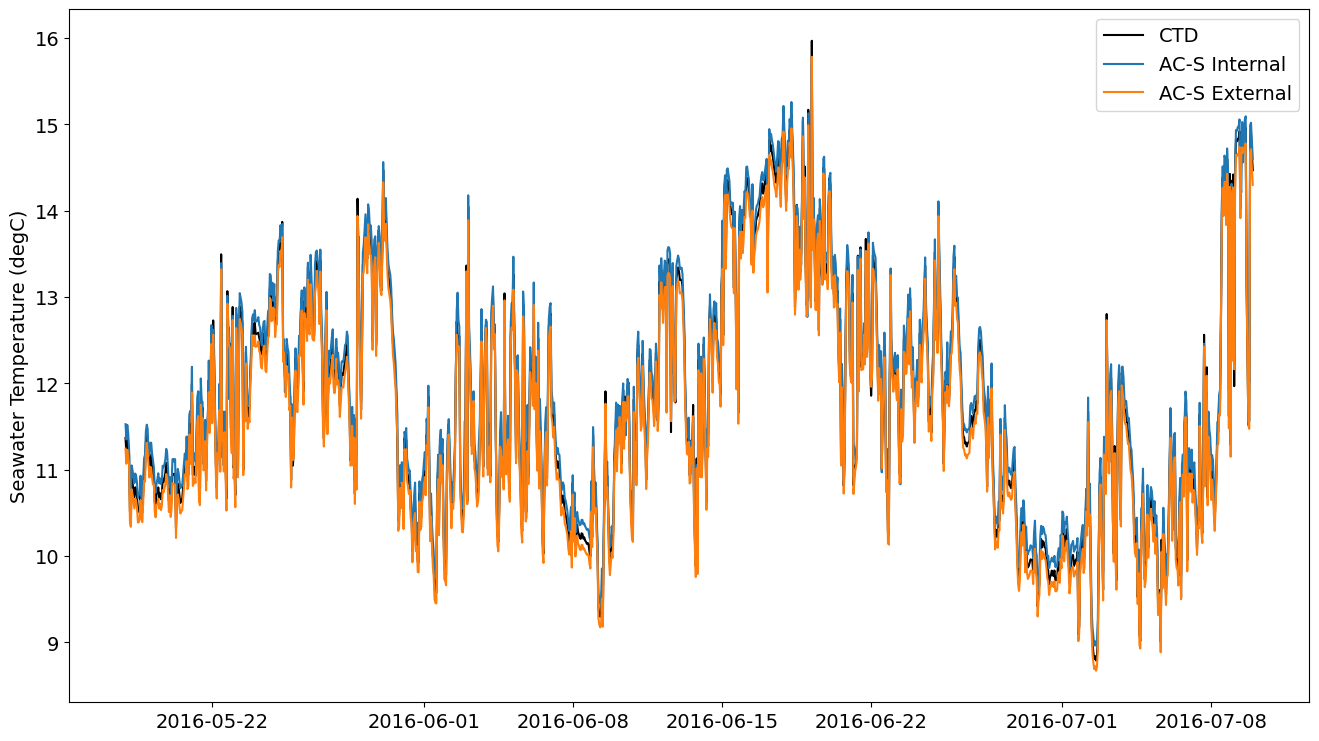

In [7]:
%matplotlib inline

# Plot the instrument and co-located CTD temperature records
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,9))
plt.plot(optaa['time'], optaa['sea_water_temperature'], '-k', label='CTD')
plt.plot(optaa['time'], optaa['internal_temp'], label='AC-S Internal')
plt.plot(optaa['time'], optaa['external_temp'], label='AC-S External')
plt.ylabel('Seawater Temperature (degC)')
plt.legend()

In [8]:
from ooi_data_explorations.uncabled.process_flort import flort_datalogger

# Setup needed parameters for the request
site = 'CE02SHSM'           # OOI Net site designator
node = 'RID27'              # OOI Net node designator
sensor = '02-FLORTD000'     # OOI Net sensor designator
stream = 'flort_sample'     # OOI Net stream name
method = 'recovered_host'   # OOI Net data delivery method
level = 'nsif'              # local directory name, level below site
instrmt = 'flort'           # local directory name, instrument below level

# We are after the the data from deployment 3
vocab = get_vocabulary(site, node, sensor)[0]
deploy = 3

# load data from the local kdata directory
flort = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*FLORT*.nc' % deploy))
flort = flort_datalogger(flort, burst=True)
flort = flort.sel(time=slice('2016-05-17T00:00:00', '2016-07-09T23:59:50'))

# create an estimate of POC from the particulate backscatter data
flort['estimated_poc'] = 53607 * (flort['bback'] - flort['sea_water_scattering_coefficient']) + 2.5  # derived from Cetinic et al., 2012 and references there in

Loading and Processing Data Files: 100%|██████████| 1/1 [00:15<00:00, 15.45s/it]


Merging the data files into a single dataset


In [9]:
# show the FLORT dataset
flort

<xarray.Dataset> Size: 2MB
Dimensions:                                    (time: 5078, stats: 3)
Coordinates:
  * time                                       (time) datetime64[ns] 41kB 201...
  * stats                                      (stats) int32 12B 0 1 2
Data variables: (12/31)
    estimated_chlorophyll_qc_results           (time) float64 41kB 29.0 ... 29.0
    fluorometric_cdom                          (time) float64 41kB 2.19 ... 2...
    fluorometric_cdom_qc_executed              (time) float64 41kB 29.0 ... 29.0
    fluorometric_cdom_qartod_results           (time) float64 41kB 1.0 ... 1.0
    fluorometric_chlorophyll_a_qartod_results  (time) float64 41kB 1.0 ... 1.0
    beta_700_qc_executed                       (time) float64 41kB 29.0 ... 29.0
    ...                                         ...
    beta_700_qc_summary_flag                   (time) float64 41kB 1.0 ... 3.0
    fluorometric_cdom_qc_summary_flag          (time) float64 41kB 1.0 ... 1.0
    fluorometric_cdom_burst_stats              (time, stats) float64 122kB 1....
    estimated_chlorophyll_burst_stats          (time, stats) float64 122kB 2....
    beta_700_burst_stats                       (time, stats) float64 122kB 0....
    estimated_poc                              (time) float64 41kB 209.9 ... ...
Attributes: (12/69)
    node:                               RID27
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             flort_sample
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                44.63565
    lon:                                -124.30427

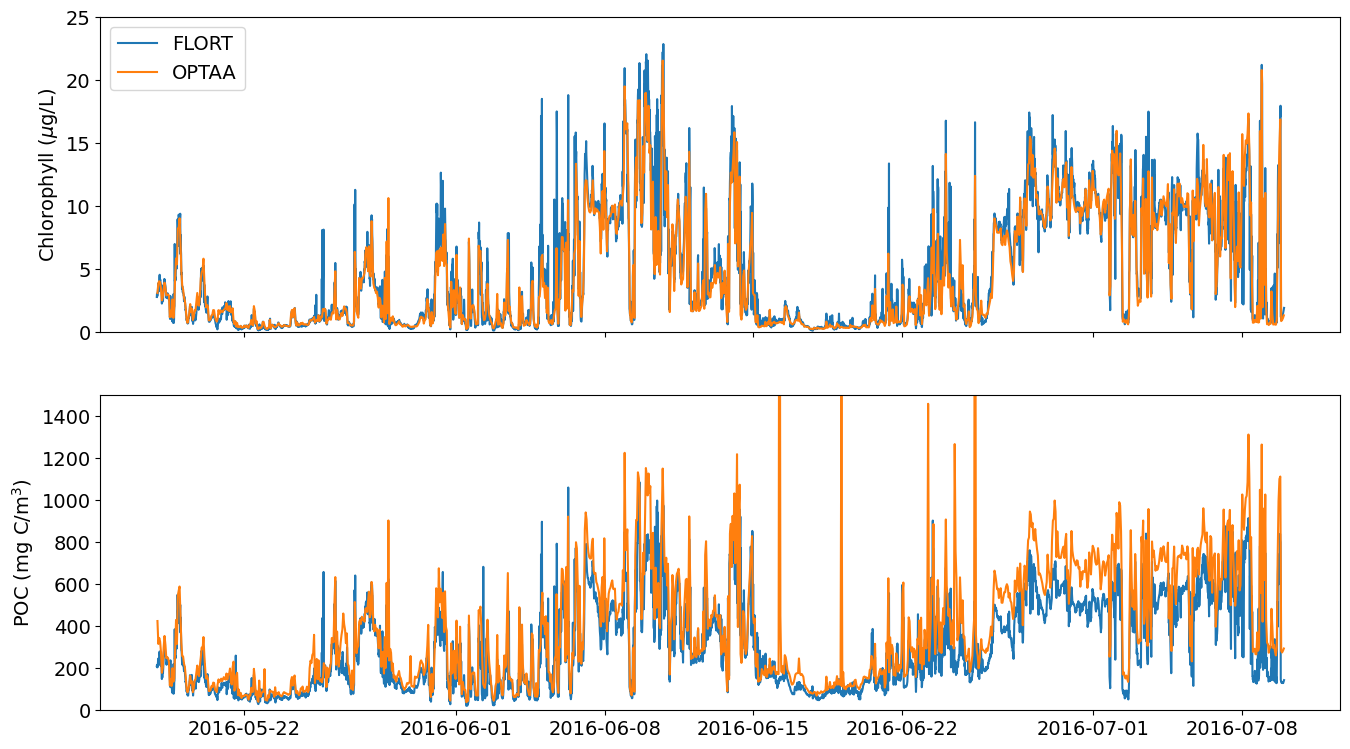

In [10]:
# plot the estimated chlorophyll and POC concentrations
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,9))

ax1 = plt.subplot(211)
plt.plot(flort['time'], flort['estimated_chlorophyll'], label='FLORT')
plt.plot(optaa['time'], optaa['estimated_chlorophyll'], label='OPTAA')
plt.ylabel('Chlorophyll ($\mu$g/L)')
plt.setp(ax1.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.ylim([0, 25])
plt.legend(loc='upper left')

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(flort['time'], flort['estimated_poc'])
plt.plot(optaa['time'], optaa['estimated_poc'])
plt.ylabel('POC (mg C/m$^3$)')
plt.ylim([0, 1500])
plt.show()

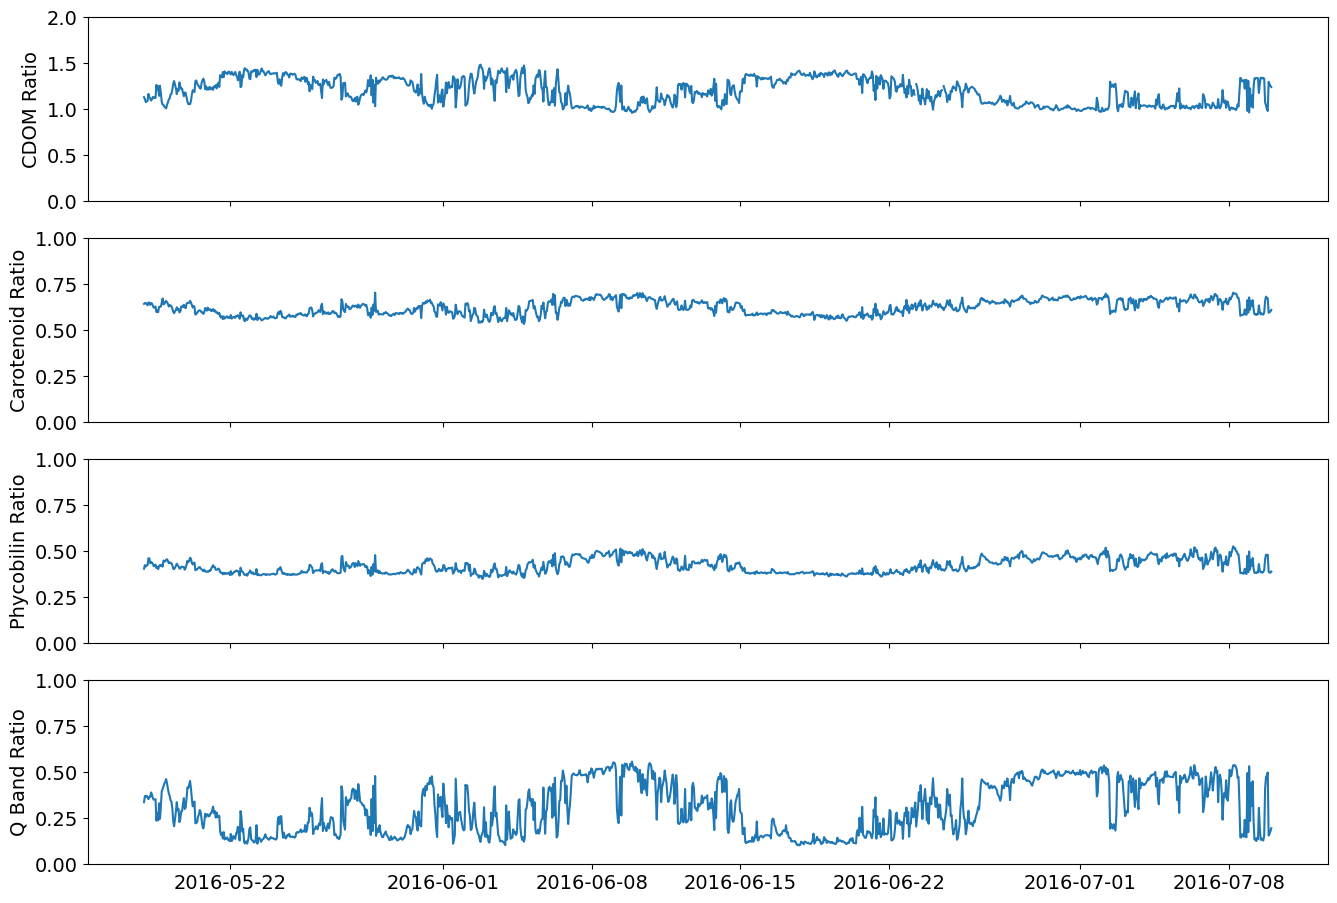

In [11]:
# plot the pigment ratios
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,11))

ax1 = plt.subplot(411)
plt.plot(optaa['time'], optaa['ratio_cdom'])
plt.ylabel('CDOM Ratio')
plt.setp(ax1.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.ylim([0, 2])

ax2 = plt.subplot(412, sharex=ax1)
plt.plot(optaa['time'], optaa['ratio_carotenoids'])
plt.ylabel('Carotenoid Ratio')
plt.setp(ax2.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.ylim([0, 1])

ax3 = plt.subplot(413, sharex=ax1)
plt.plot(optaa['time'], optaa['ratio_phycobilins'])
plt.ylabel('Phycobilin Ratio')
plt.setp(ax3.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.ylim([0, 1])

ax4 = plt.subplot(414, sharex=ax1)
plt.plot(optaa['time'], optaa['ratio_qband'])
plt.ylabel('Q Band Ratio')
plt.ylim([0, 1])

plt.show()

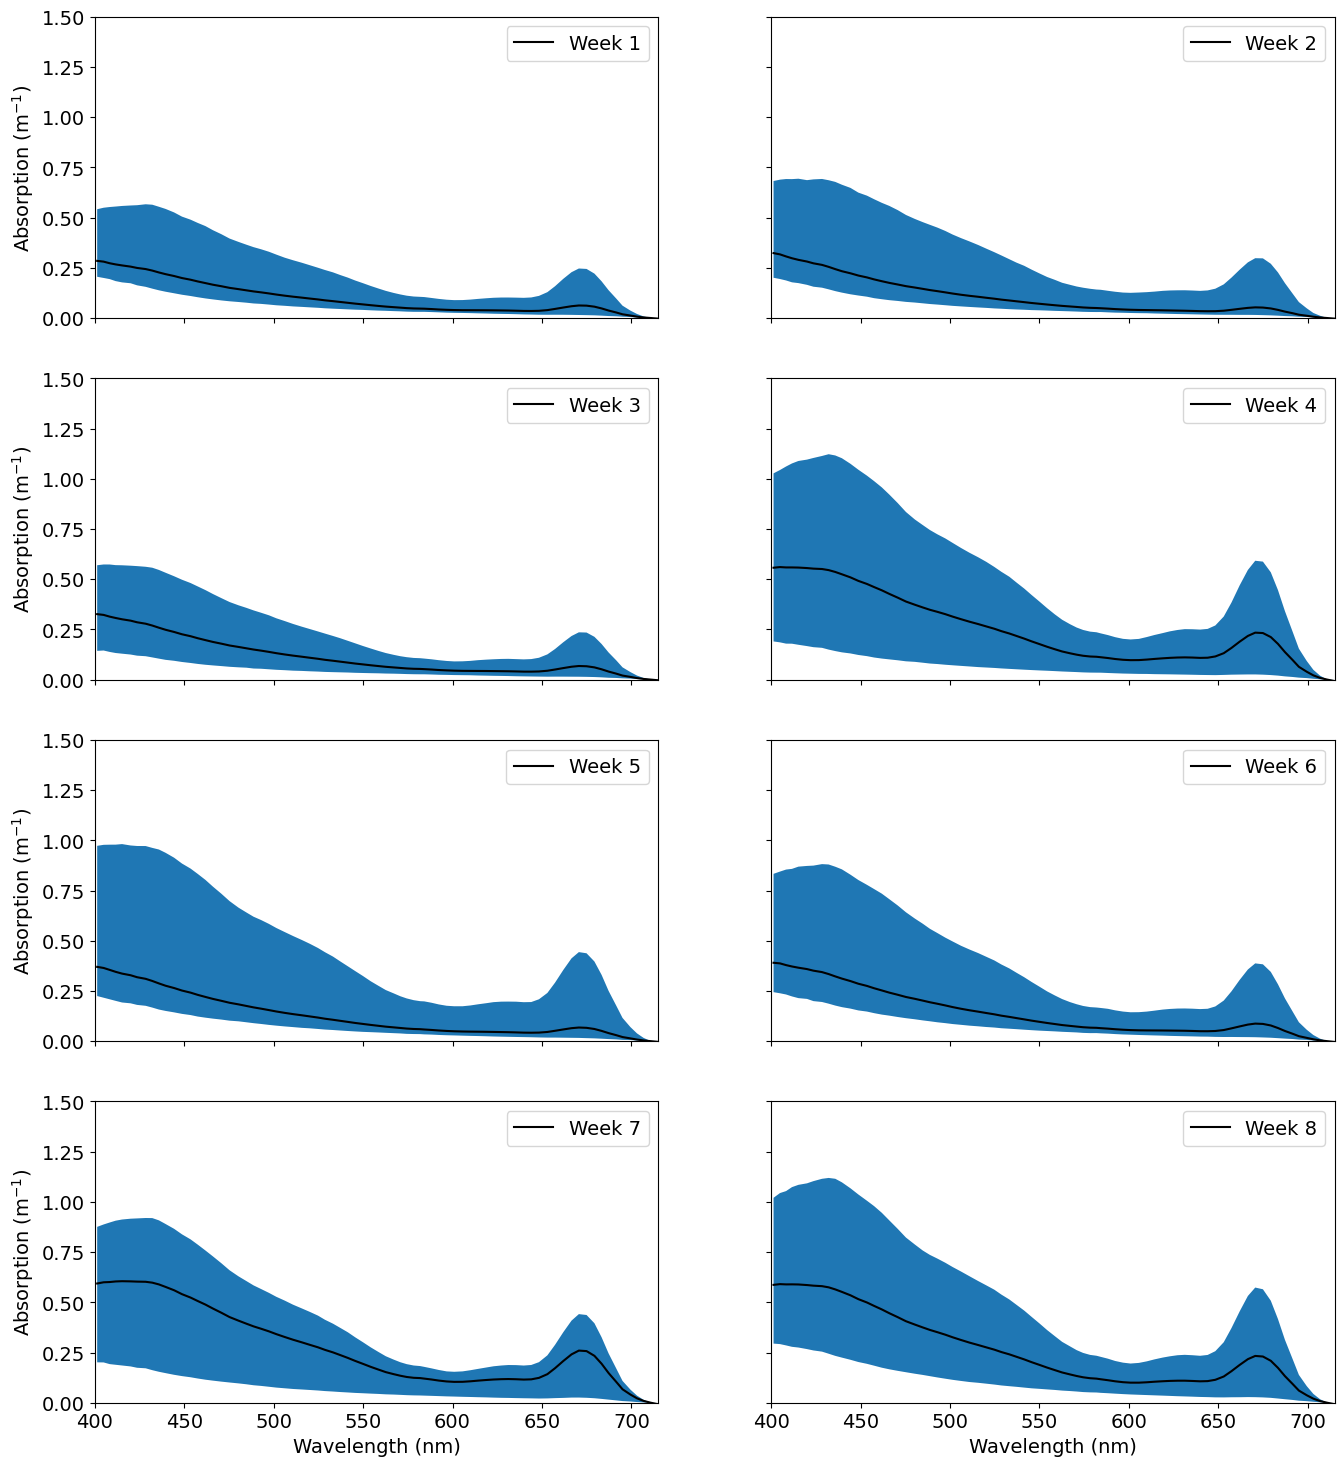

In [12]:
# create groups of data organized by the week
weeks = optaa.groupby('time.week').groups
nweek = [i for i,k in weeks.items()]

# plot weekly summaries of the absorption spectra (the mean and the min and max range)
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,18))

ax1 = plt.subplot(421)
week = optaa.isel(time=weeks[nweek[0]])
plt.plot(week['wavelength_a'][0, :], week['apg_ts_s'].mean(axis=0), '-k', label='Week 1')
plt.fill_between(week['wavelength_a'][0, :], week['apg_ts_s'].min(axis=0), week['apg_ts_s'].max(axis=0))
plt.ylim([0, 1.5])
plt.ylabel('Absorption (m$^{-1}$)')
plt.xlim([400, 715])
plt.setp(ax1.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.legend()

ax2 = plt.subplot(422, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[nweek[1]])
plt.plot(week['wavelength_a'][0, :], week['apg_ts_s'].mean(axis=0), '-k', label='Week 2')
plt.fill_between(week['wavelength_a'][0, :], week['apg_ts_s'].min(axis=0), week['apg_ts_s'].max(axis=0))
plt.setp(ax2.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.setp(ax2.get_yticklabels(), visible=False) # turn off y-axis ticklabels
plt.legend()

ax3 = plt.subplot(423, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[nweek[2]])
plt.plot(week['wavelength_a'][0, :], week['apg_ts_s'].mean(axis=0), '-k', label='Week 3')
plt.fill_between(week['wavelength_a'][0, :], week['apg_ts_s'].min(axis=0), week['apg_ts_s'].max(axis=0))
plt.setp(ax3.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.ylabel('Absorption (m$^{-1}$)')
plt.legend()

ax4 = plt.subplot(424, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[nweek[3]])
plt.plot(week['wavelength_a'][0, :], week['apg_ts_s'].mean(axis=0), '-k', label='Week 4')
plt.fill_between(week['wavelength_a'][0, :], week['apg_ts_s'].min(axis=0), week['apg_ts_s'].max(axis=0))
plt.setp(ax4.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.setp(ax4.get_yticklabels(), visible=False) # turn off y-axis ticklabels
plt.legend()

ax5 = plt.subplot(425, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[nweek[4]])
plt.plot(week['wavelength_a'][0, :], week['apg_ts_s'].mean(axis=0), '-k', label='Week 5')
plt.fill_between(week['wavelength_a'][0, :], week['apg_ts_s'].min(axis=0), week['apg_ts_s'].max(axis=0))
plt.setp(ax5.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.ylabel('Absorption (m$^{-1}$)')
plt.legend()

ax6 = plt.subplot(426, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[nweek[5]])
plt.plot(week['wavelength_a'][0, :], week['apg_ts_s'].mean(axis=0), '-k', label='Week 6')
plt.fill_between(week['wavelength_a'][0, :], week['apg_ts_s'].min(axis=0), week['apg_ts_s'].max(axis=0))
plt.setp(ax6.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.setp(ax6.get_yticklabels(), visible=False) # turn off y-axis ticklabels
plt.legend()

ax7 = plt.subplot(427, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[nweek[6]])
plt.plot(week['wavelength_a'][0, :], week['apg_ts_s'].mean(axis=0), '-k', label='Week 7')
plt.fill_between(week['wavelength_a'][0, :], week['apg_ts_s'].min(axis=0), week['apg_ts_s'].max(axis=0))
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorption (m$^{-1}$)')
plt.legend()

ax8 = plt.subplot(428, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[nweek[7]])
plt.plot(week['wavelength_a'][0, :], week['apg_ts_s'].mean(axis=0), '-k', label='Week 8')
plt.fill_between(week['wavelength_a'][0, :], week['apg_ts_s'].min(axis=0), week['apg_ts_s'].max(axis=0))
plt.xlabel('Wavelength (nm)')
plt.setp(ax8.get_yticklabels(), visible=False) # turn off y-axis ticklabels
plt.legend()

plt.show()

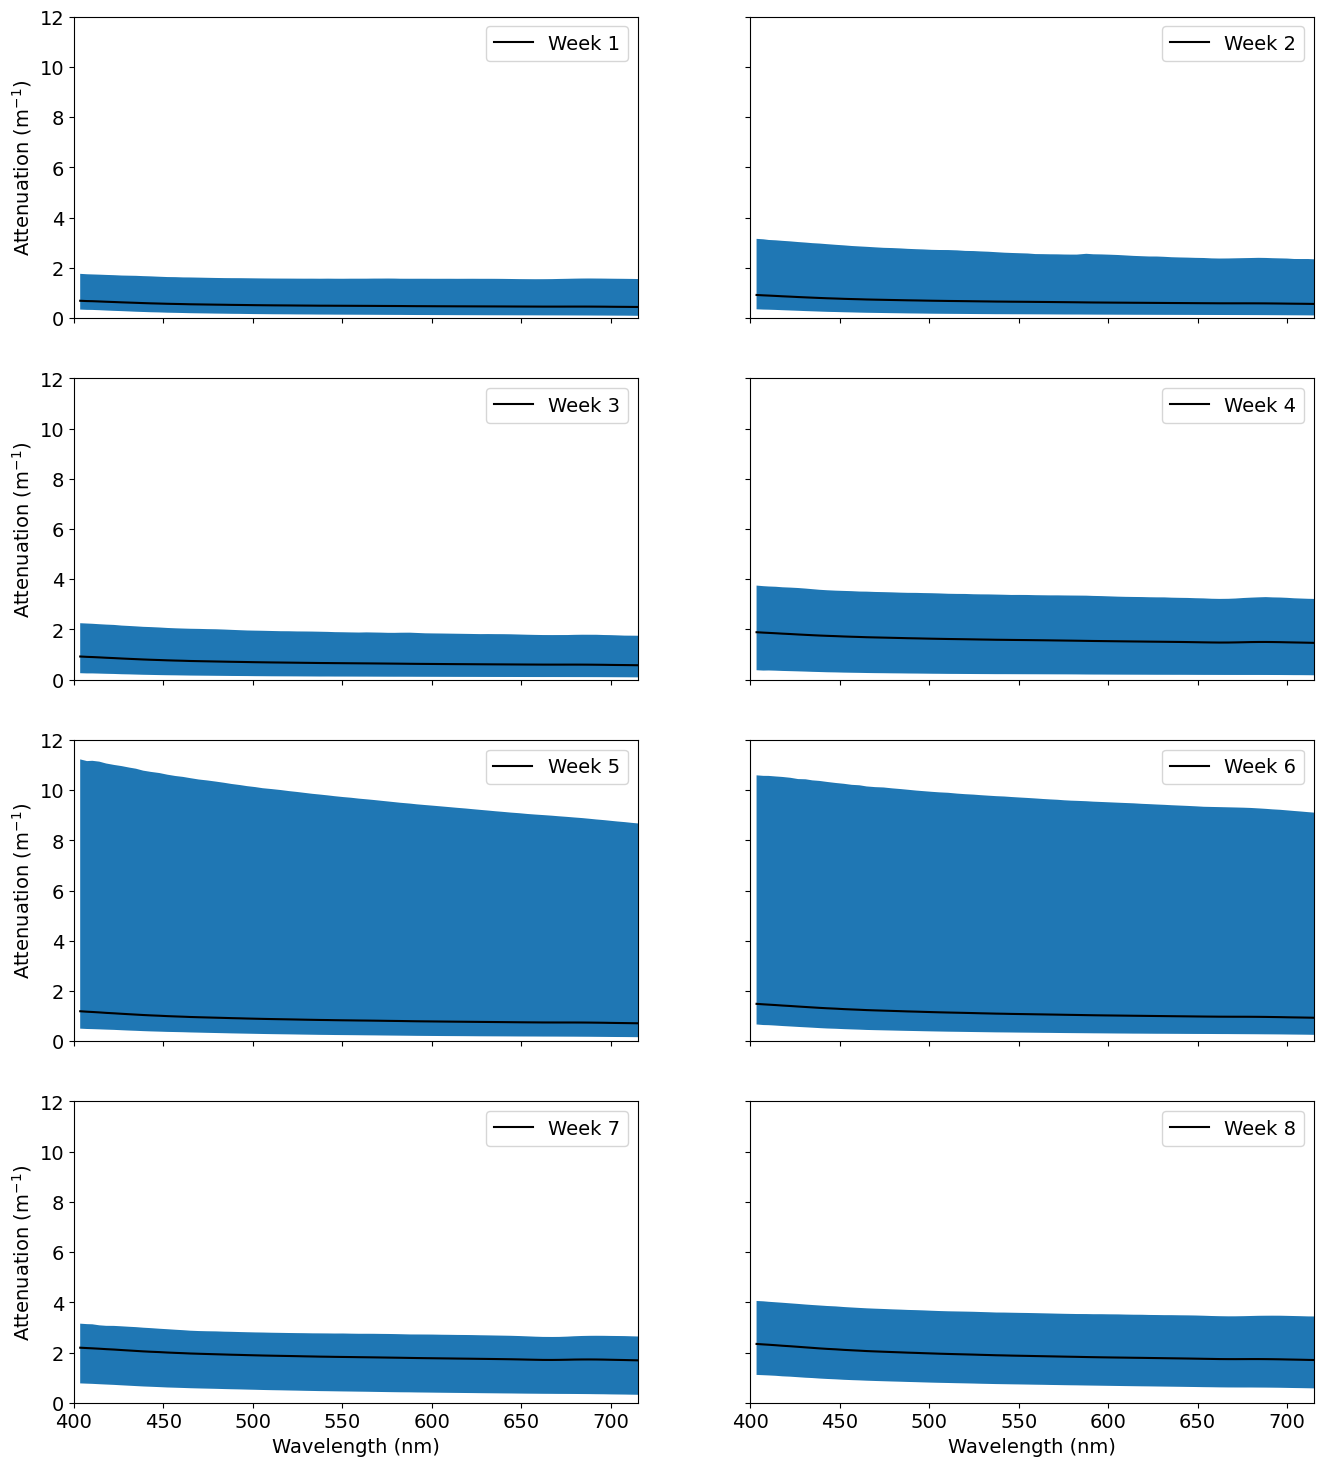

In [13]:
# plot weekly summaries of the attenuation spectra (the mean and the min and max range)
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,18))

ax1 = plt.subplot(421)
week = optaa.isel(time=weeks[nweek[0]])
plt.plot(week['wavelength_c'][0, :], week['cpg_ts'].mean(axis=0), '-k', label='Week 1')
plt.fill_between(week['wavelength_c'][0, :], week['cpg_ts'].min(axis=0), week['cpg_ts'].max(axis=0))
plt.ylim([0, 12])
plt.ylabel('Attenuation (m$^{-1}$)')
plt.xlim([400, 715])
plt.setp(ax1.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.legend()

ax2 = plt.subplot(422, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[nweek[1]])
plt.plot(week['wavelength_c'][0, :], week['cpg_ts'].mean(axis=0), '-k', label='Week 2')
plt.fill_between(week['wavelength_c'][0, :], week['cpg_ts'].min(axis=0), week['cpg_ts'].max(axis=0))
plt.setp(ax2.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.setp(ax2.get_yticklabels(), visible=False) # turn off y-axis ticklabels
plt.legend()

ax3 = plt.subplot(423, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[nweek[2]])
plt.plot(week['wavelength_c'][0, :], week['cpg_ts'].mean(axis=0), '-k', label='Week 3')
plt.fill_between(week['wavelength_c'][0, :], week['cpg_ts'].min(axis=0), week['cpg_ts'].max(axis=0))
plt.setp(ax3.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.ylabel('Attenuation (m$^{-1}$)')
plt.legend()

ax4 = plt.subplot(424, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[nweek[3]])
plt.plot(week['wavelength_c'][0, :], week['cpg_ts'].mean(axis=0), '-k', label='Week 4')
plt.fill_between(week['wavelength_c'][0, :], week['cpg_ts'].min(axis=0), week['cpg_ts'].max(axis=0))
plt.setp(ax4.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.setp(ax4.get_yticklabels(), visible=False) # turn off y-axis ticklabels
plt.legend()

ax5 = plt.subplot(425, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[nweek[4]])
plt.plot(week['wavelength_c'][0, :], week['cpg_ts'].mean(axis=0), '-k', label='Week 5')
plt.fill_between(week['wavelength_c'][0, :], week['cpg_ts'].min(axis=0), week['cpg_ts'].max(axis=0))
plt.setp(ax5.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.ylabel('Attenuation (m$^{-1}$)')
plt.legend()

ax6 = plt.subplot(426, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[nweek[5]])
plt.plot(week['wavelength_c'][0, :], week['cpg_ts'].mean(axis=0), '-k', label='Week 6')
plt.fill_between(week['wavelength_c'][0, :], week['cpg_ts'].min(axis=0), week['cpg_ts'].max(axis=0))
plt.setp(ax6.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.setp(ax6.get_yticklabels(), visible=False) # turn off y-axis ticklabels
plt.legend()

ax7 = plt.subplot(427, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[nweek[6]])
plt.plot(week['wavelength_c'][0, :], week['cpg_ts'].mean(axis=0), '-k', label='Week 7')
plt.fill_between(week['wavelength_c'][0, :], week['cpg_ts'].min(axis=0), week['cpg_ts'].max(axis=0))
plt.xlabel('Wavelength (nm)')
plt.ylabel('Attenuation (m$^{-1}$)')
plt.legend()

ax8 = plt.subplot(428, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[nweek[7]])
plt.plot(week['wavelength_c'][0, :], week['cpg_ts'].mean(axis=0), '-k', label='Week 8')
plt.fill_between(week['wavelength_c'][0, :], week['cpg_ts'].min(axis=0), week['cpg_ts'].max(axis=0))
plt.xlabel('Wavelength (nm)')
plt.setp(ax8.get_yticklabels(), visible=False) # turn off y-axis ticklabels
plt.legend()

plt.show()